# 3. Instance segmentation model inferencing

![Example](img/example1.jpg)

## Introduction
The notebook demonstrates how to perform instance segmentation using an AutoML process in Azure Machine Learning. It focuses on inferencing (making predictions) with a trained model.

## AutoML process
![Example](img/automlprocess.png)

## Documentation
- https://learn.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview
- https://learn.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?view=azureml-api-2&tabs=cli#supported-model-architectures

## Tutorials & Notebooks
- https://github.com/Azure/azureml-examples/blob/main/sdk/python/jobs/automl-standalone-jobs/automl-image-instance-segmentation-task-fridge-items/automl-image-instance-segmentation-task-fridge-items.ipynb

In [1]:
import asyncio
import base64
import cv2
import datetime
import gradio as gr
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import platform
import psutil
import shutil
import sys
import tempfile
import time

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
from matplotlib.patches import Polygon as MPLPolygon, Rectangle
from PIL import Image, ImageDraw, ImageFont

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 13-Nov-2025 08:34:17


In [4]:
processor = platform.processor()
cpu_count = psutil.cpu_count(logical=True)
ram_total = round(psutil.virtual_memory().total / (1024**3), 2)
ram_available = round(psutil.virtual_memory().available / (1024**3), 2)

disk_total, disk_used, disk_free = shutil.disk_usage("/")
disk_total_gb = disk_total / (1024**3)
disk_free_gb = disk_free / (1024**3)
disk_free_percent = disk_free / disk_total

print(f"🖥️ Processor: {processor}")
print(f"🧠 CPU Cores: {cpu_count}")
print(f"💾 RAM Total: {ram_total} GB")
print(f"📗 RAM Available: {ram_available} GB")
print(f"📀 Disk Total: {disk_total_gb:.2f} GB")
print(f"📂 Disk Free: {disk_free_gb:.2f} GB ({disk_free_percent:.0%})")

🖥️ Processor: x86_64
🧠 CPU Cores: 48
💾 RAM Total: 188.88 GB
📗 RAM Available: 183.64 GB
📀 Disk Total: 118.05 GB
📂 Disk Free: 39.63 GB (34%)


## 1. Settings

In [5]:
load_dotenv("azure.env")

ml_client = MLClient(
    credential= DefaultAzureCredential(),
    subscription_id=os.getenv("subscription_id"),
    resource_group_name=os.getenv("resource_group"),
    workspace_name=os.getenv("workspace"),
)

In [6]:
online_endpoint_name = "streetview-vision-mngd-endpoint"
deployment_name = "streetview-mlflow"

In [7]:
MODEL_DIR = "model"

os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

## 2. Helper

In [9]:
def get_predictions(image_file: str) -> dict:
    """
    Sends an image to an online endpoint for prediction and returns the results.

    Args:
        image_file (str): Path to the image file.

    Returns:
        dict: Prediction results from the endpoint.
    """
    # Reading & encoding image
    with open(image_file, "rb") as img:
        encoded_image = base64.encodebytes(img.read()).decode("utf-8")

    # Payload
    request_json = {
        "input_data": {
            "columns": ["image"],
            "data": [encoded_image],
        }
    }

    request_file_name = os.path.join(MODEL_DIR, "request.json")

    # Opening file
    with open(request_file_name, "w") as request_file:
        json.dump(request_json, request_file)

    # Calling the endpoint
    response = ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name=deployment_name,
        request_file=request_file_name,
    )

    return json.loads(response)

In [10]:
def print_results(image_file: str, results: list) -> tuple[int, int, int]:
    """
    Prints prediction results for an image and returns counts of detected objects.

    Args:
        results (list): Prediction results from the model.
        image_file (str): Name or path of the image file.

    Returns:
        tuple[int, int, int]: Counts of cars, pedestrians, and total tags.
    """
    # Parsing the results
    labels = [item['label'] for item in results[0]['boxes']]
    nb_cars = labels.count('car')
    nb_pedestrians = labels.count('pedestrian')
    nb_tags = len(labels)

    # Printing the results
    print(f"Predictions for image: '{image_file}'\n")
    print(f"🚗 Detected cars = {nb_cars}")
    print(f"🚶 Detected pedestrians = {nb_pedestrians}")
    print(f"📊 Total = {nb_tags}")

    return nb_cars, nb_pedestrians, nb_tags

In [11]:
def view_results(image_path: str,
                 results: list,
                 min_conf: float = 0.5) -> None:
    """
    Visualizes detection results on an image with bounding boxes and polygons.

    Args:
        image_path (str): Path to the image file.
        results (list): Prediction results containing 'boxes' with labels, scores, and polygons.
        min_conf (float): Minimum confidence threshold for displaying detections.
    """
    alpha = 0.5

    # Loading image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Could not load image from {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]

    # Creating plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img_rgb)

    # Legend handles
    legend_handles = []
    labels_seen = set()

    # Process detections
    for result in results:
        for detection in result['boxes']:
            if detection['score'] >= min_conf:
                label = detection['label']
                score = detection['score']
                box = detection['box']
                polygon = detection['polygon']
                color_polygon = "lime" if label == "car" else "cyan" if label == "pedestrian" else "black"
                color_bbox = "green" if label == "car" else "lightblue" if label == "pedestrian" else "black"

                # Convert normalized coordinates
                x1 = box['topX'] * width
                y1 = box['topY'] * height
                x2 = box['bottomX'] * width
                y2 = box['bottomY'] * height

                # Draw bounding box
                rect = Rectangle((x1, y1),
                                 x2 - x1,
                                 y2 - y1,
                                 linewidth=4,
                                 edgecolor=color_bbox,
                                 facecolor='none',
                                 linestyle='-')
                ax.add_patch(rect)

                # Draw polygon with transparency
                poly_points = []
                for i in range(0, len(polygon[0]), 2):
                    x = polygon[0][i] * width
                    y = polygon[0][i + 1] * height
                    poly_points.append([x, y])

                poly = MPLPolygon(
                    poly_points,
                    facecolor=color_polygon,
                    edgecolor=color_polygon,
                    linewidth=5,
                    alpha=alpha,
                )
                ax.add_patch(poly)

                # Add label
                ax.text(x1,
                        y1 - 10,
                        f'{label.upper()} = {score*100:.2f}%',
                        bbox=dict(boxstyle='round,pad=0.5',
                                  facecolor=color_polygon,
                                  alpha=1),
                        fontsize=10,
                        fontweight='bold',
                        color='black')

                # Add to legend
                if label not in labels_seen:
                    legend_handles.append(
                        mpatches.Patch(color=color_polygon,
                                       label=label.upper()))
                    labels_seen.add(label)

        # Styling
        ax.axis('off')
        ax.set_title(f"Predictions for image file '{image_path}'",
                     fontsize=12,
                     fontweight='bold',
                     pad=20)

        # Add legend
        if legend_handles:
            ax.legend(handles=legend_handles,
                      loc='upper right',
                      fontsize=10,
                      framealpha=0.9)

        plt.tight_layout()

        # Saving the image
        output_image_file = os.path.join(
            RESULTS_DIR,
            f"{os.path.splitext(os.path.basename(image_path))[0]}_predictions.jpg"
        )
        plt.savefig(output_image_file)

        plt.show()
        return output_image_file

In [12]:
def extract_and_display_objects(image_path, predictions, min_conf=0.5, ncols=5):
    """
    Extract each detected object and display as separate images
    
    Args:
        image_path: Path to the original image
        predictions: JSON predictions object with boxes
        min_conf: Minimum confidence threshold
    """
    # Load the original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    
    # Filter predictions by confidence
    boxes = [box for box in predictions[0]['boxes'] if box['score'] >= min_conf]
    
    # Create figure with subplots
    n_boxes = len(boxes)
    rows = (n_boxes + ncols - 1) // ncols
    
    fig, axes = plt.subplots(rows, ncols, figsize=(6, 5*rows))
    axes = axes.flatten() if n_boxes > 1 else [axes]

    for idx, box_data in enumerate(boxes):
        box = box_data['box']
        label = box_data['label']
        score = box_data['score']
        
        # Convert normalized coordinates to pixel coordinates
        x1 = int(box['topX'] * w)
        y1 = int(box['topY'] * h)
        x2 = int(box['bottomX'] * w)
        y2 = int(box['bottomY'] * h)
        
        # Extract the object region
        cropped = image_rgb[y1:y2, x1:x2]
        
        # Display in subplot
        axes[idx].imshow(cropped)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_boxes, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()

    plt.show()

In [13]:
def extract_and_display_polygons(image_path, predictions, min_conf=0.5, ncols=5):
    """
    Extract and display only the polygon regions for each detected object
    
    Args:
        image_path: Path to the original image
        predictions: JSON predictions object with polygons
        min_conf: Minimum confidence threshold
    """
    # Load the original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    
    # Filter predictions by confidence
    boxes = [box for box in predictions[0]['boxes'] if box['score'] >= min_conf]
    
    # Create figure with subplots
    n_boxes = len(boxes)
    rows = (n_boxes + ncols - 1) // ncols

    fig, axes = plt.subplots(rows, ncols, figsize=(6, 5*rows))
    axes = axes.flatten() if n_boxes > 1 else [axes]
    
    for idx, box_data in enumerate(boxes):
        label = box_data['label']
        score = box_data['score']
        polygon = box_data['polygon'][0]  # Get the polygon coordinates
        
        # Convert normalized coordinates to pixel coordinates
        polygon_points = []
        for i in range(0, len(polygon), 2):
            x = int(polygon[i] * w)
            y = int(polygon[i+1] * h)
            polygon_points.append([x, y])
        
        polygon_points = np.array(polygon_points, dtype=np.int32)
        
        # Create a mask for the polygon
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [polygon_points], 255)
        
        # Apply mask to extract only polygon region
        masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
        
        # Get bounding box to crop the result
        x, y, w_box, h_box = cv2.boundingRect(polygon_points)
        cropped = masked_image[y:y+h_box, x:x+w_box]
        
        # Display in subplot
        axes[idx].imshow(cropped)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_boxes, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. Testing

In [14]:
TEST_DIR = "tests"

test_images_list = [
    os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)
    if os.path.splitext(f)[1].lower() in
    {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
]

In [15]:
len(test_images_list)

14

### Example 1

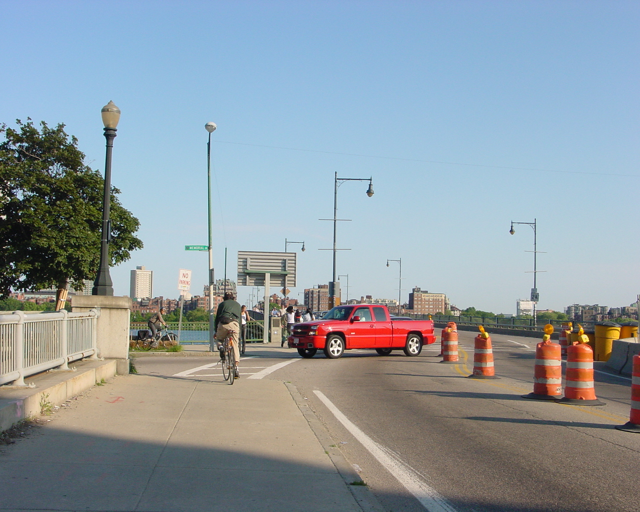

In [16]:
test_image = test_images_list[4]

img = Image.open(test_image)
img.resize((640, 512))

In [17]:
start = time.time()
predictions = get_predictions(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

✅ Done in 1.718 seconds


In [18]:
print_results(test_image, predictions)

Predictions for image: 'tests/test_005.jpg'

🚗 Detected cars = 1
🚶 Detected pedestrians = 3
📊 Total = 4


(1, 3, 4)

In [19]:
boxes = predictions[0]['boxes']

df_predictions = pd.DataFrame([{
    'label': box['label'],
    'score': box['score'],
    'topX': box['box']['topX'],
    'topY': box['box']['topY'],
    'bottomX': box['box']['bottomX'],
    'bottomY': box['box']['bottomY'],
    'polygon': box['polygon']
} for box in boxes])

df_predictions

label     score      topX      topY   bottomX   bottomY  \
0         car  0.996347  0.447310  0.586173  0.687507  0.703692   
1  pedestrian  0.852526  0.328652  0.554179  0.381841  0.735979   
2  pedestrian  0.787372  0.437148  0.580678  0.465861  0.682417   
3  pedestrian  0.542098  0.371955  0.590346  0.394314  0.697292   

                                             polygon  
0  [[0.53875, 0.7033333333333334, 0.47, 0.7016666...  
1  [[0.37125, 0.7183333333333334, 0.37, 0.7066666...  
2  [[0.45625, 0.6816666666666666, 0.43625, 0.68, ...  
3  [[0.38, 0.6966666666666667, 0.3775, 0.695, 0.3...

In [20]:
for index, row in df_predictions.iterrows():
    label = row['label']
    score = row['score']

    # Choose emoji and color indicator
    if score >= 0.95:
        emoji = '🟢'  # Green - Excellent
        confidence = 'EXCELLENT'
    elif score >= 0.90:
        emoji = '🟢'  # Green - Very good
        confidence = 'VERY GOOD'
    elif score >= 0.80:
        emoji = '🟡'  # Yellow - Good
        confidence = 'GOOD'
    elif score >= 0.70:
        emoji = '🟠'  # Orange - Fair
        confidence = 'FAIR'
    else:
        emoji = '🔴'  # Red - Poor
        confidence = 'LOW'

    # Create progress bar
    bar_length = 30
    filled = int(bar_length * score)
    bar = '█' * filled + '░' * (bar_length - filled)
    print()
    print(f"{emoji} {label:15} │ {bar} │ {score:.2%} ({confidence})")


🟢 car             │ █████████████████████████████░ │ 99.63% (EXCELLENT)

🟡 pedestrian      │ █████████████████████████░░░░░ │ 85.25% (GOOD)

🟠 pedestrian      │ ███████████████████████░░░░░░░ │ 78.74% (FAIR)

🔴 pedestrian      │ ████████████████░░░░░░░░░░░░░░ │ 54.21% (LOW)


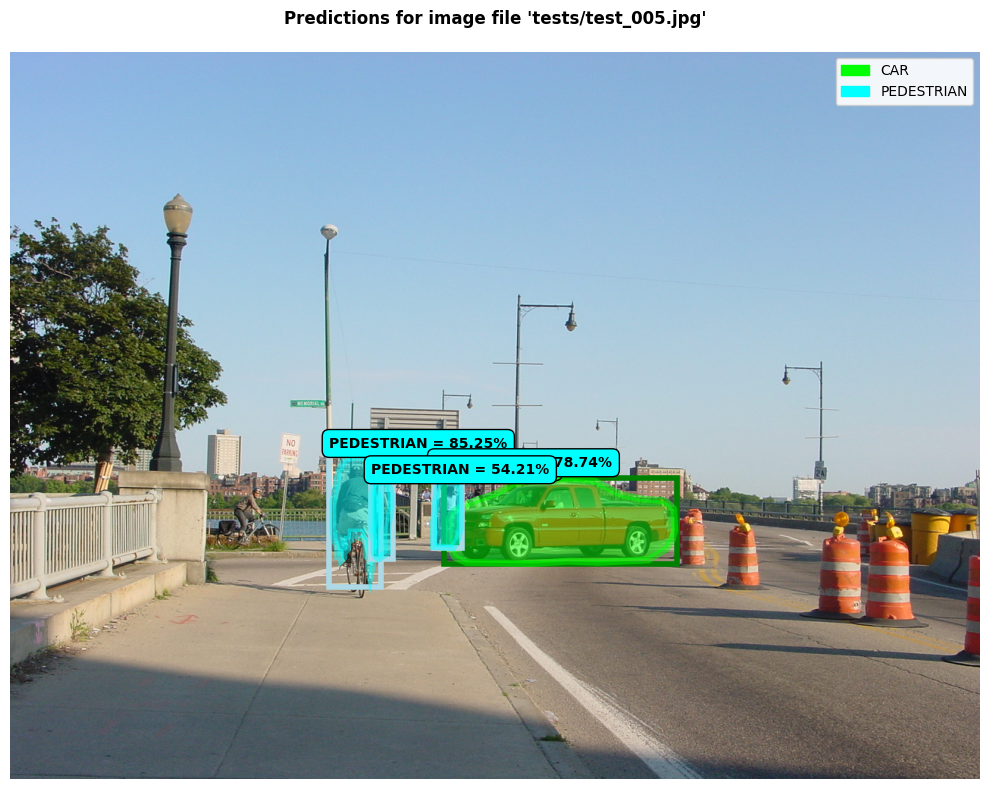

'results/test_005_predictions.jpg'

In [21]:
view_results(test_image, predictions, min_conf=0.5)

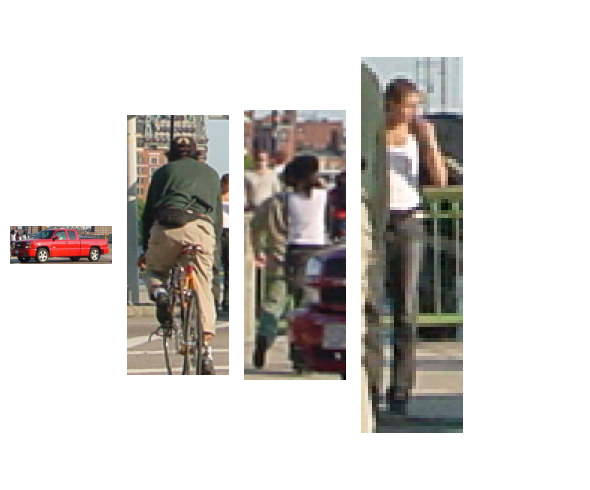

In [22]:
extract_and_display_objects(test_image, predictions, min_conf=0.5, ncols=5)

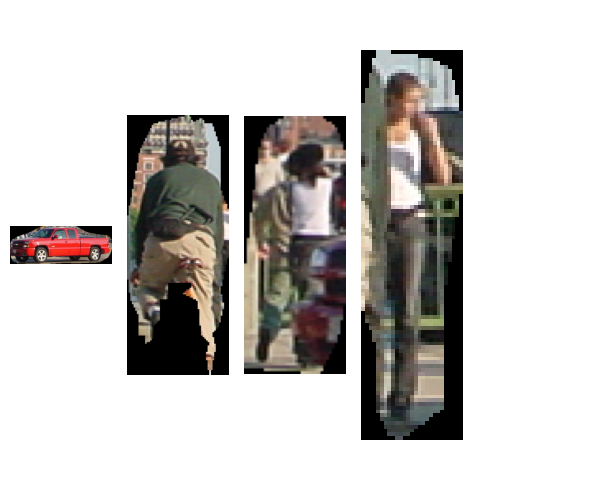

In [23]:
extract_and_display_polygons(test_image, predictions, min_conf=0.5, ncols=5)

### Example 2

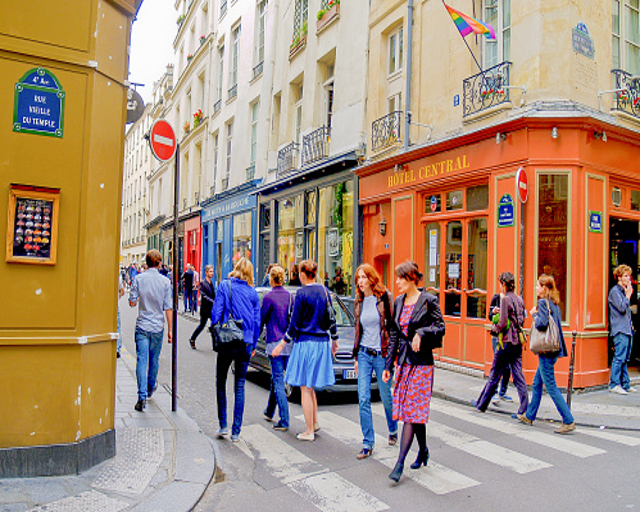

In [24]:
test_image = test_images_list[10]

img = Image.open(test_image)
img.resize((640, 512))

In [25]:
start = time.time()
predictions = get_predictions(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

✅ Done in 1.371 seconds


In [26]:
print_results(test_image, predictions)

Predictions for image: 'tests/test_011.jpg'

🚗 Detected cars = 0
🚶 Detected pedestrians = 13
📊 Total = 13


(0, 13, 13)

In [27]:
boxes = predictions[0]['boxes']

df_predictions = pd.DataFrame([{
    'label': box['label'],
    'score': box['score'],
    'topX': box['box']['topX'],
    'topY': box['box']['topY'],
    'bottomX': box['box']['bottomX'],
    'bottomY': box['box']['bottomY'],
    'polygon': box['polygon']
} for box in boxes])

df_predictions

label     score      topX      topY   bottomX   bottomY  \
0   pedestrian  0.987449  0.588961  0.498151  0.702969  0.963528   
1   pedestrian  0.986199  0.540526  0.495856  0.618703  0.916742   
2   pedestrian  0.982565  0.940953  0.508668  0.997728  0.783487   
3   pedestrian  0.981674  0.440543  0.486156  0.530746  0.878773   
4   pedestrian  0.980740  0.815522  0.520376  0.901259  0.841267   
5   pedestrian  0.980265  0.316013  0.479912  0.419459  0.877705   
6   pedestrian  0.977076  0.744027  0.517127  0.831137  0.820134   
7   pedestrian  0.976906  0.191574  0.470025  0.281471  0.811795   
8   pedestrian  0.973624  0.401757  0.504176  0.467069  0.858922   
9   pedestrian  0.906057  0.293877  0.507748  0.349129  0.696135   
10  pedestrian  0.716609  0.557718  0.500178  0.663131  0.950246   
11  pedestrian  0.716573  0.280359  0.503201  0.311039  0.618725   
12  pedestrian  0.447975  0.762948  0.516107  0.878174  0.846946   

                                              polygon  
0   [[0.6184971098265896, 0.9583333333333334, 0.60...  
1   [[0.5583815028901734, 0.91, 0.5572254335260116...  
2   [[0.9780346820809248, 0.7783333333333333, 0.96...  
3   [[0.48323699421965316, 0.8733333333333333, 0.4...  
4   [[0.8936416184971099, 0.8416666666666667, 0.85...  
5   [[0.3560693641618497, 0.8733333333333333, 0.33...  
6   [[0.8184971098265896, 0.8183333333333334, 0.80...  
7   [[0.22196531791907514, 0.8116666666666666, 0.2...  
8   [[0.45202312138728323, 0.8533333333333334, 0.4...  
9   [[0.33410404624277457, 0.6866666666666666, 0.3...  
10  [[0.623121387283237, 0.95, 0.6104046242774567,...  
11  [[0.3040462427745665, 0.6183333333333333, 0.28...  
12  [[0.8728323699421965, 0.84, 0.8682080924855491...

In [28]:
for index, row in df_predictions.iterrows():
    label = row['label']
    score = row['score']

    # Choose emoji and color indicator
    if score >= 0.95:
        emoji = '🟢'  # Green - Excellent
        confidence = 'EXCELLENT'
    elif score >= 0.90:
        emoji = '🟢'  # Green - Very good
        confidence = 'VERY GOOD'
    elif score >= 0.80:
        emoji = '🟡'  # Yellow - Good
        confidence = 'GOOD'
    elif score >= 0.70:
        emoji = '🟠'  # Orange - Fair
        confidence = 'FAIR'
    else:
        emoji = '🔴'  # Red - Poor
        confidence = 'LOW'

    # Create progress bar
    bar_length = 30
    filled = int(bar_length * score)
    bar = '█' * filled + '░' * (bar_length - filled)
    print()
    print(f"{emoji} {label:15} │ {bar} │ {score:.2%} ({confidence})")


🟢 pedestrian      │ █████████████████████████████░ │ 98.74% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 98.62% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 98.26% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 98.17% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 98.07% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 98.03% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 97.71% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 97.69% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 97.36% (EXCELLENT)

🟢 pedestrian      │ ███████████████████████████░░░ │ 90.61% (VERY GOOD)

🟠 pedestrian      │ █████████████████████░░░░░░░░░ │ 71.66% (FAIR)

🟠 pedestrian      │ █████████████████████░░░░░░░░░ │ 71.66% (FAIR)

🔴 pedestrian      │ █████████████░░░░░░░░░░░░░░░░░ │ 44.80% (LOW)


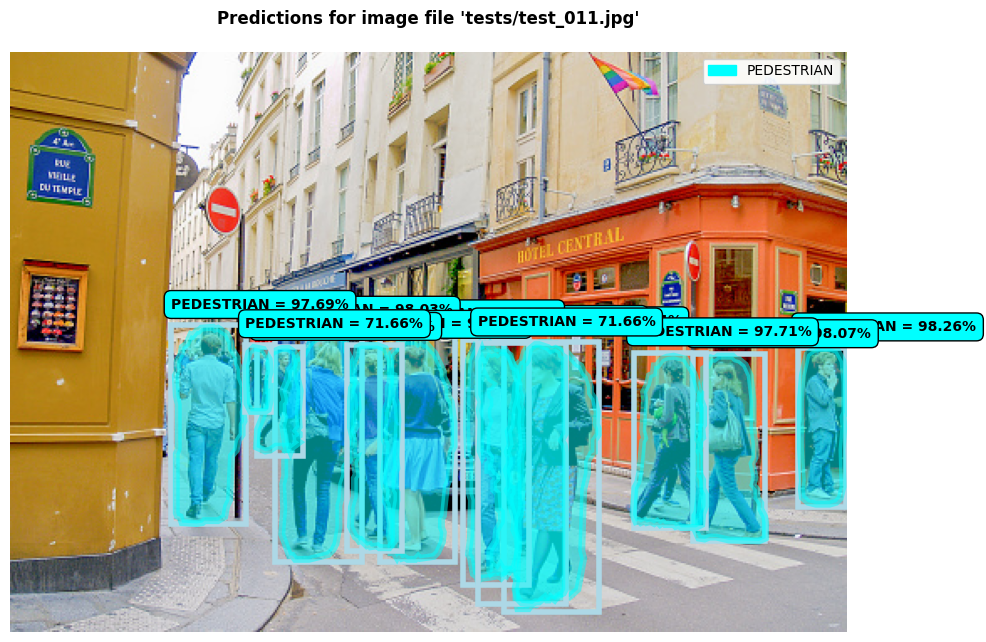

'results/test_011_predictions.jpg'

In [29]:
view_results(test_image, predictions, min_conf=0.5)

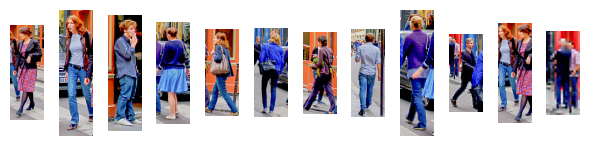

In [30]:
extract_and_display_objects(test_image, predictions, min_conf=0.5, ncols=12)

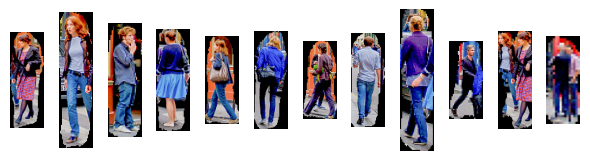

In [31]:
extract_and_display_polygons(test_image, predictions, min_conf=0.5, ncols=12)

### Example 3

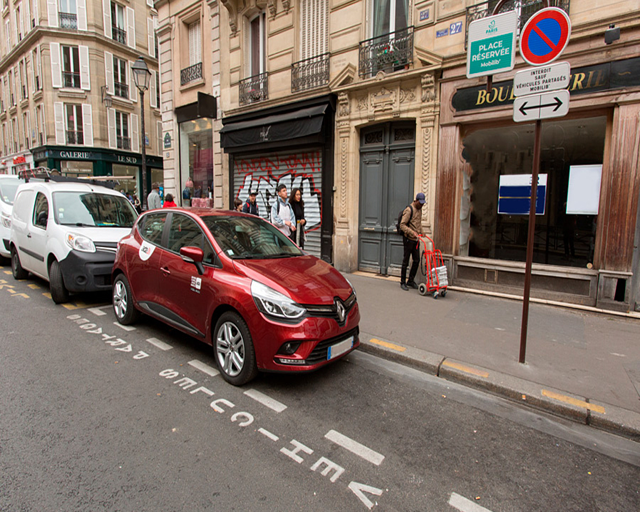

In [32]:
test_image = test_images_list[12]

img = Image.open(test_image)
img.resize((640, 512))

In [33]:
start = time.time()
predictions = get_predictions(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

✅ Done in 1.518 seconds


In [34]:
print_results(test_image, predictions)

Predictions for image: 'tests/test_013.jpg'

🚗 Detected cars = 2
🚶 Detected pedestrians = 3
📊 Total = 5


(2, 3, 5)

In [35]:
boxes = predictions[0]['boxes']

df_predictions = pd.DataFrame([{
    'label': box['label'],
    'score': box['score'],
    'topX': box['box']['topX'],
    'topY': box['box']['topY'],
    'bottomX': box['box']['bottomX'],
    'bottomY': box['box']['bottomY'],
    'polygon': box['polygon']
} for box in boxes])

df_predictions

label     score      topX      topY   bottomX   bottomY  \
0         car  0.993333  0.157537  0.392605  0.577973  0.755761   
1  pedestrian  0.975948  0.615883  0.364776  0.673462  0.575233   
2         car  0.916633  0.006825  0.340180  0.254211  0.599099   
3  pedestrian  0.759684  0.415092  0.364265  0.470109  0.529956   
4  pedestrian  0.542030  0.449188  0.351950  0.487556  0.509175   

                                             polygon  
0  [[0.41458333333333336, 0.7483333333333333, 0.3...  
1  [[0.65625, 0.5733333333333334, 0.6302083333333...  
2  [[0.13958333333333334, 0.5966666666666667, 0.0...  
3  [[0.44895833333333335, 0.5283333333333333, 0.4...  
4  [[0.46145833333333336, 0.5066666666666667, 0.4...

In [36]:
for index, row in df_predictions.iterrows():
    label = row['label']
    score = row['score']

    # Choose emoji and color indicator
    if score >= 0.95:
        emoji = '🟢'  # Green - Excellent
        confidence = 'EXCELLENT'
    elif score >= 0.90:
        emoji = '🟢'  # Green - Very good
        confidence = 'VERY GOOD'
    elif score >= 0.80:
        emoji = '🟡'  # Yellow - Good
        confidence = 'GOOD'
    elif score >= 0.70:
        emoji = '🟠'  # Orange - Fair
        confidence = 'FAIR'
    else:
        emoji = '🔴'  # Red - Poor
        confidence = 'LOW'

    # Create progress bar
    bar_length = 30
    filled = int(bar_length * score)
    bar = '█' * filled + '░' * (bar_length - filled)
    print()
    print(f"{emoji} {label:15} │ {bar} │ {score:.2%} ({confidence})")


🟢 car             │ █████████████████████████████░ │ 99.33% (EXCELLENT)

🟢 pedestrian      │ █████████████████████████████░ │ 97.59% (EXCELLENT)

🟢 car             │ ███████████████████████████░░░ │ 91.66% (VERY GOOD)

🟠 pedestrian      │ ██████████████████████░░░░░░░░ │ 75.97% (FAIR)

🔴 pedestrian      │ ████████████████░░░░░░░░░░░░░░ │ 54.20% (LOW)


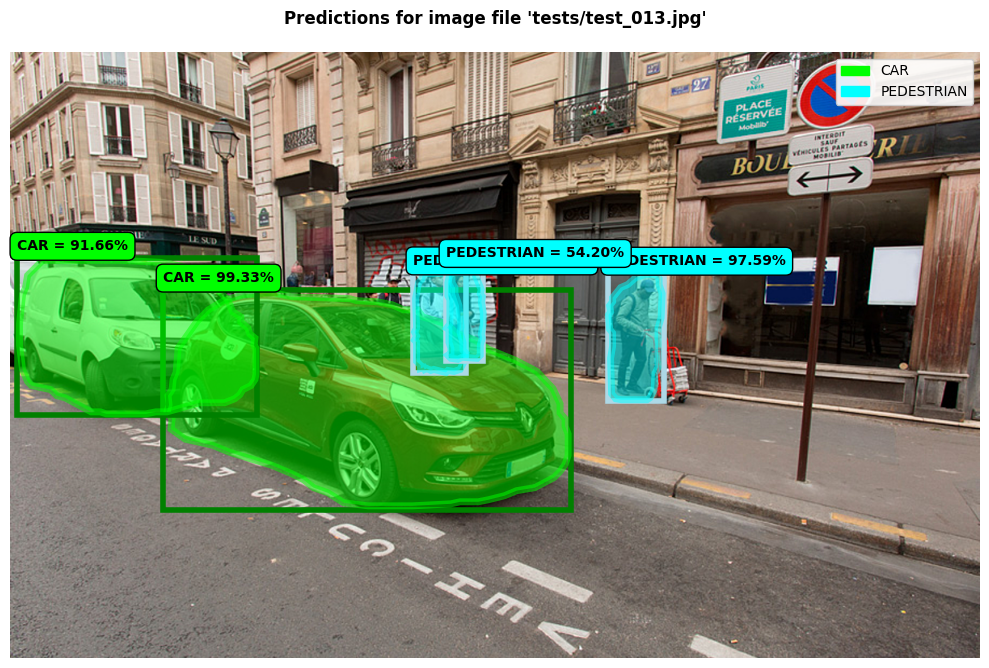

'results/test_013_predictions.jpg'

In [37]:
view_results(test_image, predictions, min_conf=0.5)

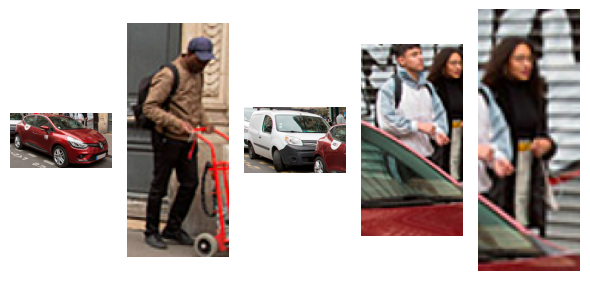

In [38]:
extract_and_display_objects(test_image, predictions, min_conf=0.5)

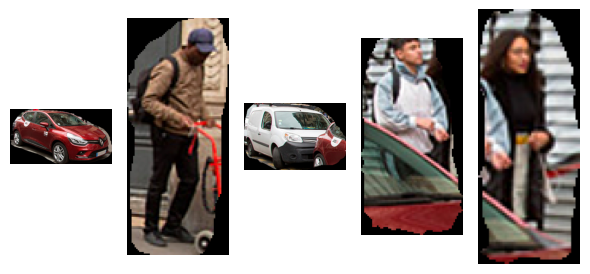

In [39]:
extract_and_display_polygons(test_image, predictions, min_conf=0.5)

## 4. Batch mode

In [40]:
print("🏃 Running the object detection model on all files of dir 'test'...\n")

start = time.time()
all_predictions = []

for idx, file in enumerate(test_images_list):
    print(f"{idx+1:03} Analysing '{test_images_list[idx]}'")
    predictions = get_predictions(test_images_list[idx])
    all_predictions.append({
        'filename': test_images_list[idx],
        'predictions': predictions
    })

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"\n⌛ Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")
time_per_image = elapsed / len(test_images_list)
print(f"⏰ Average time per image = {time_per_image:.3f} seconds")

🏃 Running the object detection model on all files of dir 'test'...

001 Analysing 'tests/test_001.jpg'
002 Analysing 'tests/test_002.jpg'
003 Analysing 'tests/test_003.jpg'
004 Analysing 'tests/test_004.jpg'
005 Analysing 'tests/test_005.jpg'
006 Analysing 'tests/test_006.jpg'
007 Analysing 'tests/test_007.jpg'
008 Analysing 'tests/test_008.jpg'
009 Analysing 'tests/test_009.jpg'
010 Analysing 'tests/test_010.jpg'
011 Analysing 'tests/test_011.jpg'
012 Analysing 'tests/test_012.jpg'
013 Analysing 'tests/test_013.jpg'
014 Analysing 'tests/test_014.jpg'

⌛ Elapsed time = 0 minutes and 18 seconds
⏰ Average time per image = 1.277 seconds


In [41]:
df = pd.DataFrame(all_predictions)
df

filename                                        predictions
0   tests/test_001.jpg  [{'boxes': [{'box': {'topX': 0.245748265822877...
1   tests/test_002.jpg  [{'boxes': [{'box': {'topX': 0.048939647674560...
2   tests/test_003.jpg  [{'boxes': [{'box': {'topX': 0.567780380249023...
3   tests/test_004.jpg  [{'boxes': [{'box': {'topX': 0.583655624389648...
4   tests/test_005.jpg  [{'boxes': [{'box': {'topX': 0.447310256958007...
5   tests/test_006.jpg  [{'boxes': [{'box': {'topX': 0.536704025268554...
6   tests/test_007.jpg  [{'boxes': [{'box': {'topX': 0.510349731445312...
7   tests/test_008.jpg  [{'boxes': [{'box': {'topX': 0.409453582763671...
8   tests/test_009.jpg  [{'boxes': [{'box': {'topX': 0.095849733352661...
9   tests/test_010.jpg  [{'boxes': [{'box': {'topX': 0.220600337982177...
10  tests/test_011.jpg  [{'boxes': [{'box': {'topX': 0.588960680658417...
11  tests/test_012.jpg  [{'boxes': [{'box': {'topX': 0.315884245368988...
12  tests/test_013.jpg  [{'boxes': [{'box': {'topX': 0.157536919911702...
13  tests/test_014.jpg  [{'boxes': [{'box': {'topX': 0.660753899136641...

In [42]:
nb_cars = nb_peds = nb_labels = 0

for filename, predictions in zip(df['filename'], df['predictions']):
    nb_car, nb_ped, nb_label = print_results(filename, predictions)
    print("\n" + "-" * 50 + "\n")
    nb_cars += nb_car
    nb_peds += nb_ped
    nb_labels += nb_label

print(f"Summary:")
print(f"🚗 Cars detected = {nb_cars}")
print(f"🚶 Pedestrians detected = {nb_peds}")
print(f"📊 Total objects detected = {nb_labels}")

Predictions for image: 'tests/test_001.jpg'

🚗 Detected cars = 4
🚶 Detected pedestrians = 2
📊 Total = 6

--------------------------------------------------

Predictions for image: 'tests/test_002.jpg'

🚗 Detected cars = 2
🚶 Detected pedestrians = 1
📊 Total = 3

--------------------------------------------------

Predictions for image: 'tests/test_003.jpg'

🚗 Detected cars = 4
🚶 Detected pedestrians = 4
📊 Total = 8

--------------------------------------------------

Predictions for image: 'tests/test_004.jpg'

🚗 Detected cars = 3
🚶 Detected pedestrians = 1
📊 Total = 4

--------------------------------------------------

Predictions for image: 'tests/test_005.jpg'

🚗 Detected cars = 1
🚶 Detected pedestrians = 3
📊 Total = 4

--------------------------------------------------

Predictions for image: 'tests/test_006.jpg'

🚗 Detected cars = 3
🚶 Detected pedestrians = 0
📊 Total = 3

--------------------------------------------------

Predictions for image: 'tests/test_007.jpg'

🚗 Detected ca

## 5. Gradio webapp

In [43]:
def process_image(image, min_confidence):
    """
    Process the uploaded image and return predictions with visualizations
    
    Args:
        image: Input image from Gradio (PIL Image)
        min_confidence: Minimum confidence threshold for displaying predictions
    
    Returns:
        tuple: (annotated_image, raw_predictions_text)
    """
    if image is None:
        return None, "Please upload an image first."

    try:
        with tempfile.NamedTemporaryFile(suffix='.jpg',
                                         delete=False) as tmp_file:
            temp_path = tmp_file.name
            image.save(temp_path)

        try:
            # Try with file path first
            predictions = get_predictions(temp_path)
        except:
            # If that fails, try with PIL Image directly
            predictions = get_predictions(image)
        finally:
            # Clean up temporary file
            if os.path.exists(temp_path):
                os.unlink(temp_path)

        # Extract boxes and create DataFrame
        boxes = predictions[0]['boxes']
        df_predictions = pd.DataFrame([{
            'label': box['label'],
            'score': box['score'],
            'topX': box['box']['topX'],
            'topY': box['box']['topY'],
            'bottomX': box['box']['bottomX'],
            'bottomY': box['box']['bottomY'],
            'polygon': str(box['polygon'])
        } for box in boxes])

        # Filter by confidence threshold
        df_filtered = df_predictions[df_predictions['score'] >= min_confidence]

        # Get annotated image with predictions
        # Try both temp_path and image object
        try:
            with tempfile.NamedTemporaryFile(suffix='.jpg',
                                             delete=False) as tmp_file:
                temp_path2 = tmp_file.name
                image.save(temp_path2)
            try:
                annotated_image = view_results(temp_path2,
                                               predictions,
                                               min_conf=min_confidence)
            except:
                annotated_image = view_results(image,
                                               predictions,
                                               min_conf=min_confidence)
            finally:
                if os.path.exists(temp_path2):
                    os.unlink(temp_path2)
        except Exception as e:
            print(f"Warning: Could not generate annotated image: {e}")
            annotated_image = image  # Return original image if annotation fails

        # Create formatted text output
        results_text = f"Found {len(df_filtered)} predictions (confidence >= {min_confidence})\n\n"
        results_text += "Predictions Summary:\n"
        results_text += "=" * 50 + "\n"

        for idx, row in df_filtered.iterrows():
            results_text += f"\nDetection #{idx + 1}:\n"
            results_text += f"  Label: {row['label']}\n"
            results_text += f"  Confidence = {row['score']:.3f}\n"
            results_text += f"  Bounding Box: ({row['topX']:.1f}, {row['topY']:.1f}) to ({row['bottomX']:.1f}, {row['bottomY']:.1f})\n"

        return annotated_image, results_text

    except Exception as e:
        import traceback
        error_msg = f"Error processing image: {str(e)}\n\n"
        error_msg += "Traceback:\n" + traceback.format_exc()
        return None, error_msg


def create_gradio_interface():
    """
    Create and configure the Gradio interface
    """
    with gr.Blocks(
            title="Instance segmentation App using Azure AutoML for Images",
            theme="soft") as webapp:
        gr.Markdown("""
            # 🔍 Instance segmentation with Azure AutoML for Images
            Adjust the confidence threshold to filter results.
            """)

        with gr.Row():
            with gr.Column(scale=1):
                # Input components
                gr.Markdown("### 📤 Image")
                image_input = gr.Image(label="Upload Image",
                                       type="pil",
                                       height=400)

                confidence_slider = gr.Slider(
                    minimum=0.0,
                    maximum=1.0,
                    value=0.5,
                    step=0.05,
                    label="Minimum Confidence Threshold",
                    info=
                    "Only show predictions with confidence above this value")

                with gr.Row():
                    process_btn = gr.Button("🚀 Run Instance Segmentation",
                                            variant="primary",
                                            size="lg")
                    clear_btn = gr.ClearButton(components=[image_input],
                                               value="Clear")

            with gr.Column(scale=1):
                # Output components
                gr.Markdown("### 📊 Results")
                output_image = gr.Image(label="Results",
                                        type="pil",
                                        height=600,
                                        elem_classes=["output-image"])

        # Additional outputs below
        with gr.Row():
            with gr.Column():
                gr.Markdown("### 📝 Detailed Results")
                output_text = gr.Textbox(label="Summary",
                                         lines=10,
                                         max_lines=100,
                                         show_copy_button=True)

        # Examples section
        gr.Markdown("### 📷 Example Images")
        gr.Examples(
            examples=[
                ["tests/test_001.jpg", 0.3],
                ["tests/test_003.jpg", 0.2],
                ["tests/test_004.jpg", 0.5],
                ["tests/test_005.jpg", 0.5],
                ["tests/test_006.jpg", 0.5],
            ],
            inputs=[image_input, confidence_slider],
            outputs=[output_image, output_text],
            fn=process_image,
            cache_examples=True,
            label="Click an example to try it")

        # Examples section
        gr.Markdown("### 💡 Tips")
        gr.Markdown("""
            - Upload any image containing objects you want to detect
            - Adjust the confidence threshold to show more or fewer predictions
            - Lower threshold = more detections (but potentially less accurate)
            - Higher threshold = fewer detections (but more confident)
            """)

        # Event handlers
        process_btn.click(fn=process_image,
                          inputs=[image_input, confidence_slider],
                          outputs=[output_image, output_text])

        confidence_slider.change(fn=process_image,
                                 inputs=[image_input, confidence_slider],
                                 outputs=[output_image, output_text])

    return webapp

In [44]:
webapp = create_gradio_interface()

webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
Using cache from '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd48/code/Users/seretkow/AutoML Instance Segmentation 2025/.gradio/cached_examples/20' directory. If method or examples have changed since last caching, delete this folder to clear cache.

* Running on public URL: https://539f86e436c135bb90.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


![Example](img/gradio1.jpg)